In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import Angle, SkyCoord
from astropy.table import Table
from astropy.time import Time

In [3]:
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.datasets import Datasets, FluxPointsDataset, SpectrumDataset, SpectrumDatasetOnOff
from gammapy.data import DataStore
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.makers import ReflectedRegionsBackgroundMaker, RingBackgroundMaker, SafeMaskMaker, SpectrumDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (create_crab_spectral_model, ExpCutoffPowerLawSpectralModel, 
                                     LogParabolaSpectralModel, Models, PowerLawSpectralModel, SkyModel)

In [4]:
import logging
from pathlib import Path
from regions import CircleSkyRegion

In [5]:
def reduced_chi_sq(y, model_y, sigma, n_param):
    
    frac = (y - model_y) / sigma
    chi_sq = np.sum(frac ** 2)
    
    dof = len(y) - n_param
    
    return chi_sq, dof

In [6]:
path = 'BL_Lacertae/data/'

In [7]:
log = logging.getLogger(__name__)

In [8]:
datastore = DataStore.from_dir(path)
datastore.info()

Data store:
HDU index table:
BASE_DIR: BL_Lacertae/data
Rows: 65
OBS_ID: 83016 -- 83768
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 13



In [9]:
obs_ids = [83016, 83017, 83018, 83019, 83020, 83021]
#observations = datastore.get_observations(obs_ids, required_irf='point-like')

In [10]:
#obs_ids = obs_ids + [83231, 83266, 83368, 83389, 83523, 83558, 83768]
obs_ids.remove(83018)
#obs_ids.remove(83231)
observations = datastore.get_observations(obs_ids, required_irf='point-like')

In [11]:
len(observations)

5

In [12]:
bllacertae_ra = (22 * u.hourangle + 2 * u.arcmin + 43.2913536816 * u.arcsec).to(u.deg)
bllacertae_dec = (42 * u.deg + 16 * u.arcmin + 39.979416792 * u.arcsec).to(u.deg)

In [13]:
target_position = SkyCoord(bllacertae_ra, bllacertae_dec, frame='icrs')

In [14]:
selection = {'type': 'sky_circle', 'frame': 'icrs', 
             'lon': bllacertae_ra, 'lat': bllacertae_dec, 'radius': 2 * u.deg}

In [15]:
len(datastore.obs_table.select_observations(selection))

13

In [16]:
on_region_radius = Angle(0.08944272 * u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

In [17]:
energy_axis = MapAxis.from_energy_bounds(energy_min=0.1, energy_max=10, nbin=10, per_decade=True, 
                                         unit='TeV', name='energy')
energy_axis_true = MapAxis.from_energy_bounds(energy_min=0.1, energy_max=10, nbin=20, per_decade=True, 
                                              unit='TeV', name='energy_true')

In [18]:
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

### Not sure I understand what object this is
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

In [19]:
### Not sure I understand what objects these are

dataset_maker = SpectrumDatasetMaker(containment_correction=False, selection=['counts', 'exposure', 'edisp'])
wobble_bkg_maker = ReflectedRegionsBackgroundMaker()
#ring_bkg_maker = RingBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=['aeff-max'], aeff_percent=10)

In [20]:
datasets = Datasets()

for obs_id, obs in zip(obs_ids, observations):
    dataset_1 = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), obs)
    dataset_2 = wobble_bkg_maker.run(dataset_1, obs)
    dataset_3 = safe_mask_masker.run(dataset_2, obs)
    datasets.append(dataset_3)

print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 83016
  Instrument : VERITAS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 83017
  Instrument : VERITAS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 83019
  Instrument : VERITAS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 83020
  Instrument : VERITAS
  Models     : 

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : 83021
  Instrument : VERITAS
  Models     : 




In [22]:
info_table = datasets.info_table(cumulative=True)
display(info_table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,2,-0.6363637447357178,-0.40126280314367563,2.6363637447357178,2.608695726538876,2.608695726538876,nan,698843.0,219277040.0,1523.3331217806794,1801.0,0.0013129104667941095,0.001730654777370019,-0.0004177443105759094,20,17,wstat,6.8849123454230945,58,17.0,374.0,0.04545454680919647
stacked,4,0.2698860168457031,0.13535223335100324,3.730113983154297,3.744051725224494,3.744051725224494,nan,901452.375,419546240.0,3063.1226852352247,3602.0,0.001305856934585312,0.0012177488029239195,8.810813166139243e-05,20,17,wstat,13.095963116924958,93,17.0,423.84765625,0.04010875150561333
stacked,8,1.9971585273742676,0.7578723906279701,6.002841472625732,6.086595309761102,6.086595309761102,nan,1284138.375,660284352.0,4605.403619314253,5403.0,0.0017370898755647403,0.001303434393339787,0.0004336554822249533,20,17,wstat,17.68658267942022,143,17.0,404.9748840332031,0.041977912187576294
stacked,11,2.360795021057129,0.752852917012297,8.639204978942871,8.740817031682857,8.740817031682857,nan,1514412.0,925081536.0,6149.78143865651,7204.0,0.0017886814531091818,0.0014047987014039647,0.00038388275170521695,20,17,wstat,17.993366556840655,201,17.0,395.52252197265625,0.042981117963790894
stacked,13,2.673295021057129,0.7824218045027952,10.326704978942871,10.437738912979695,10.437738912979695,nan,1602419.75,1185139072.0,7680.788102921024,9005.0,0.0016925346495441094,0.0013444850763446525,0.00034804957319945694,20,17,wstat,19.550017826427386,255,17.0,419.785400390625,0.04049688205122948


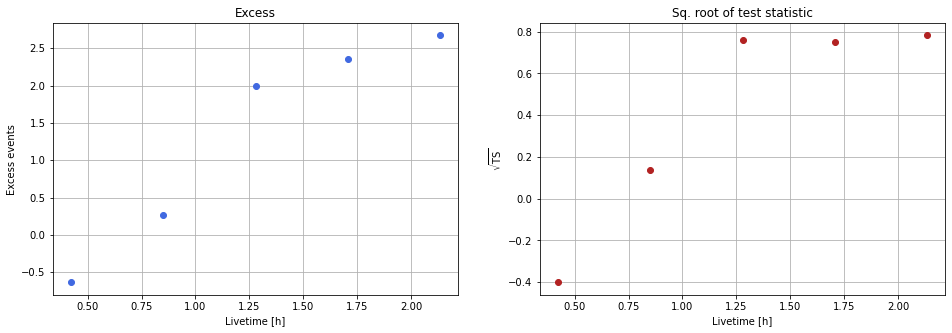

In [23]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(1, 2, figsize=(16, 5))

ax_excess.plot(info_table['livetime'].to(u.h), info_table['excess'], 'o', c='royalblue', ls='none')
ax_excess.grid()
ax_excess.set_xlabel('Livetime [h]')
ax_excess.set_ylabel('Excess events')
ax_excess.set_title('Excess')

ax_sqrt_ts.plot(info_table['livetime'].to(u.h), info_table['sqrt_ts'], 'o', c='firebrick', ls='none')
ax_sqrt_ts.grid()
ax_sqrt_ts.set_xlabel('Livetime [h]')
ax_sqrt_ts.set_ylabel(r'$\sqrt{\rm{TS}}$')
ax_sqrt_ts.set_title('Sq. root of test statistic')

plt.show()

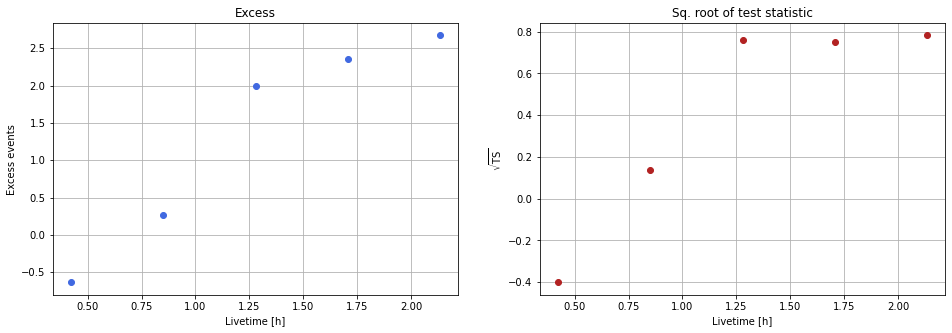

In [24]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(1, 2, figsize=(16, 5))

ax_excess.plot(info_table[:6]['livetime'].to(u.h), info_table[:6]['excess'], 'o', c='royalblue', ls='none')
ax_excess.grid()
ax_excess.set_xlabel('Livetime [h]')
ax_excess.set_ylabel('Excess events')
ax_excess.set_title('Excess')

ax_sqrt_ts.plot(info_table[:6]['livetime'].to(u.h), info_table[:6]['sqrt_ts'], 'o', c='firebrick', ls='none')
ax_sqrt_ts.grid()
ax_sqrt_ts.set_xlabel('Livetime [h]')
ax_sqrt_ts.set_ylabel(r'$\sqrt{\rm{TS}}$')
ax_sqrt_ts.set_title('Sq. root of test statistic')

plt.show()

In [25]:
spectral_model = LogParabolaSpectralModel.from_log10(amplitude=2.22e-5 / (u.m ** 2 * u.s * u.TeV), 
                                                     reference=0.2 * u.TeV, 
                                                     alpha=2.4, 
                                                     beta=1.8)

In [26]:
print(spectral_model)

LogParabolaSpectralModel

  type      name     value         unit     ... max frozen is_norm link
-------- --------- ---------- ------------- ... --- ------ ------- ----
spectral amplitude 2.2200e-05 m-2 s-1 TeV-1 ... nan  False    True     
spectral reference 2.0000e-01           TeV ... nan   True   False     
spectral     alpha 2.4000e+00               ... nan  False   False     
spectral      beta 7.8173e-01               ... nan  False   False     


In [27]:
### ???

model = SkyModel(spectral_model=spectral_model, name='BL Lacertae')
datasets.models = [model]

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)
model_best_joint = model.copy()

/Users/Leo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/Leo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/Leo/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/Leo/opt/anaconda3/lib/python3.9/site-packages/gammapy/stats/fit_statistics.py:209: RuntimeWarning: overflow encountered in square
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/Leo/opt/anaconda3/lib/python3.9/site-packages/gammapy/stats/fit_statistics.py:189: RuntimeWarning: invalid value encountered in add
  stat = 2 * (term1 + term2 + term3)
/Users/Leo/opt/anaconda3/lib/python3.9/site-packages/nump

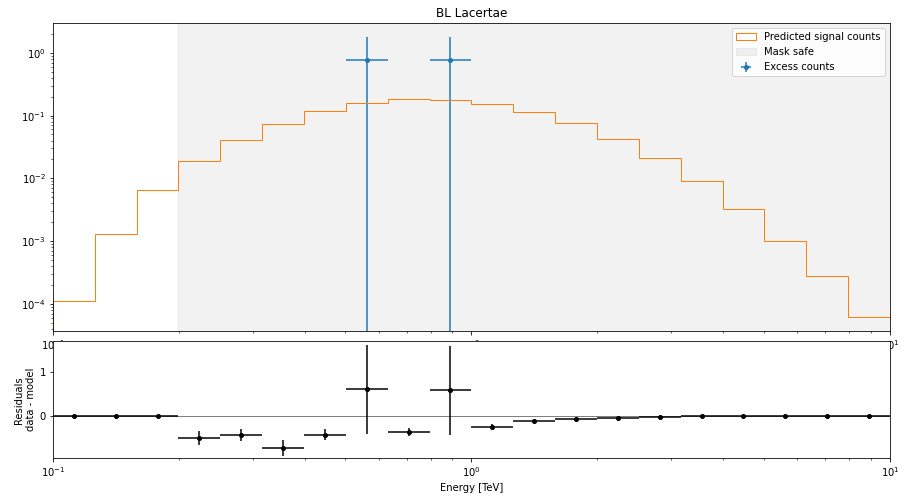

In [28]:
plt.figure(figsize=(15, 8))

ax_spectrum, ax_residuals = datasets[0].plot_fit()

ax_spectrum.set_yscale('log')
datasets[0].plot_masks(ax=ax_spectrum)
ax_spectrum.set_title('BL Lacertae')

plt.show()

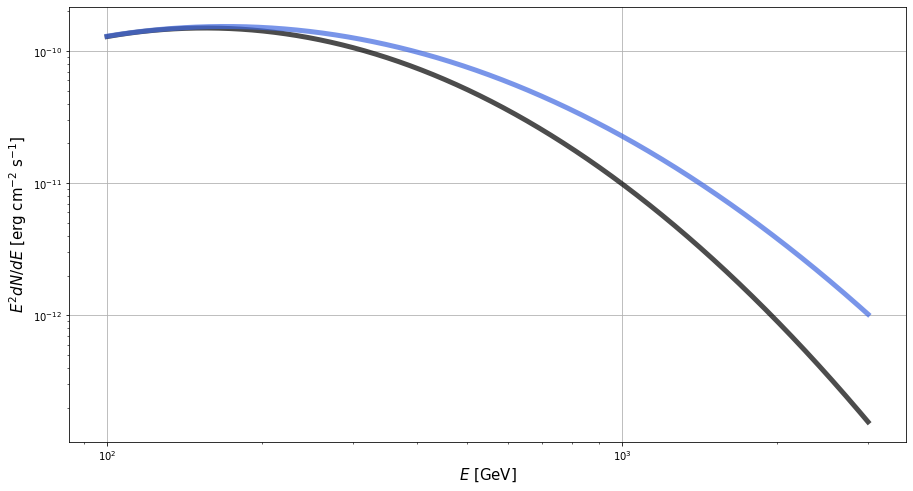

In [29]:
A1 = 2.22e-5
A2 = 2.36e-5
 
ref = 0.2

alpha1 = 2.4
alpha2 = 2.2

beta1 = 1.8
beta2 = 1.4

def logparab(E, A, ref, alpha, beta):
    return A * (E / ref) ** (-alpha - beta * np.log10((E / ref)))
    

energies = np.linspace(0.1, 3, 100000)

e2fluxes1 = logparab(energies, A1, ref, alpha1, beta1) * energies ** 2
e2fluxes2 = logparab(energies, A2, ref, alpha2, beta2) * energies ** 2
    
    
plt.figure(figsize=(15, 8))

plt.plot(energies * u.TeV.to(u.GeV), 
         e2fluxes1 * (u.TeV / u.m ** 2 / u.s).to(u.erg / u.cm ** 2 / u.s), 
         lw=5, c='k', alpha=0.7)

plt.plot(energies * u.TeV.to(u.GeV), 
         e2fluxes2 * (u.TeV / u.m ** 2 / u.s).to(u.erg / u.cm ** 2 / u.s), 
         lw=5, c='royalblue', alpha=0.7)

plt.xscale('log')
plt.xlabel(r'$E$ [GeV]', fontsize=15)

plt.yscale('log')
plt.ylabel(r'$E^2 dN/dE$ [erg cm$^{-2}$ s$^{-1}$]', fontsize=15)

plt.grid()
plt.show()

In [30]:
e_min, e_max = 0.1, 2
energy_edges = np.geomspace(e_min, e_max, 7) * u.TeV

In [31]:
fpe = FluxPointsEstimator(energy_edges=energy_edges, source='BL Lacertae', selection_optional='all')
flux_points = fpe.run(datasets=datasets)

In [32]:
flux_points.to_table(sed_type='dnde', formatted=True).show_in_notebook()

idx,e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred [5],npred_excess [5],stat,is_ul,counts [5],success,norm_scan [11],stat_scan [11]
,TeV,TeV,TeV,1 / (m2 s TeV),1 / (m2 s TeV),1 / (m2 s TeV),1 / (m2 s TeV),1 / (m2 s TeV),,,,,,,,,,
0,0.126,0.100,0.158,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,False,0.0 .. 0.0,False,0.200 .. 5.000,nan .. nan
1,0.200,0.158,0.251,-1.406e-07,2.932e-08,7.045e-08,7.045e-08,nan,2.043,-1.429,0.0 .. 0.0,-0.50425565 .. 0.0,0.002,True,0.0 .. 0.0,True,0.200 .. 5.000,2.061 .. 2.441
2,0.355,0.251,0.501,-1.169e-09,1.915e-08,2.160e-08,nan,4.849e-08,0.004,-0.061,1.3216672531492142 .. 1.005698886132684,-0.026158834 .. -0.024604144,17.868,True,0.0 .. 0.0,True,0.200 .. 5.000,17.896 .. 22.293
3,0.631,0.501,0.794,8.912e-09,1.082e-08,1.262e-08,nan,3.802e-08,0.922,0.960,0.7546153317808351 .. 0.7176501115547321,0.33681852 .. 0.3370165,6.105,True,1.0 .. 1.0,True,0.200 .. 5.000,6.655 .. 11.574
4,1.000,0.794,1.259,7.484e-09,5.200e-09,6.103e-09,4.373e-09,2.161e-08,4.293,2.072,0.8894497425422156 .. 0.7217405895391797,0.56608915 .. 0.5925865,6.251,False,1.0 .. 1.0,True,0.200 .. 5.000,9.213 .. 10.387
5,1.585,1.259,1.995,4.081e-15,2.065e-12,6.452e-10,nan,2.581e-09,-0.000,0.000,6.081013699934684e-07 .. 0.12121279046827942,6.0810135e-07 .. 6.692561e-07,0.937,True,0.0 .. 0.0,True,0.200 .. 5.000,1.333 .. 10.844


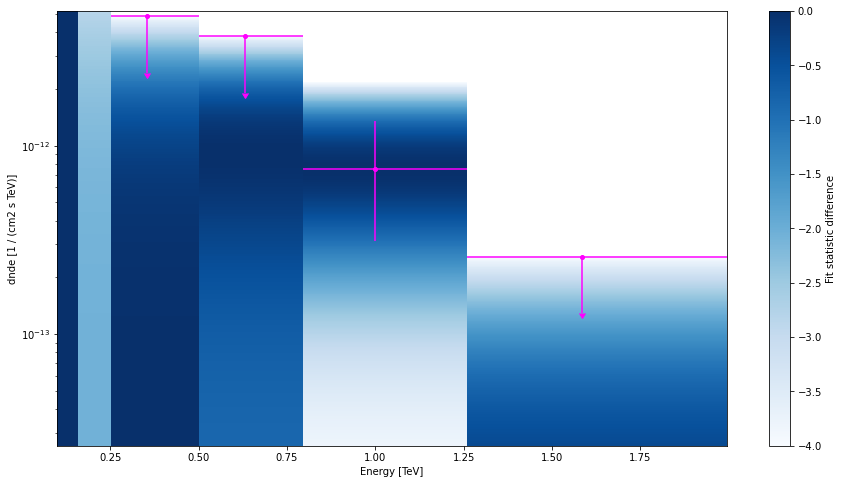

In [33]:
fig, ax = plt.subplots(figsize=(15, 8))
flux_points.plot(ax=ax, sed_type='dnde', c='fuchsia')
flux_points.plot_ts_profiles(ax=ax, sed_type='dnde')
ax.set_xscale('linear')
plt.show()

(<AxesSubplot:xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals\n (data - model) / model'>)

<Figure size 1080x576 with 0 Axes>

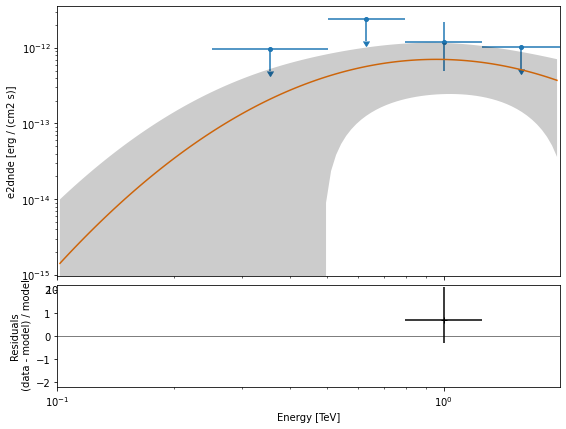

In [34]:
plt.figure(figsize=(15, 8))
flux_points_dataset = FluxPointsDataset(data=flux_points, models=model_best_joint)
flux_points_dataset.plot_fit()

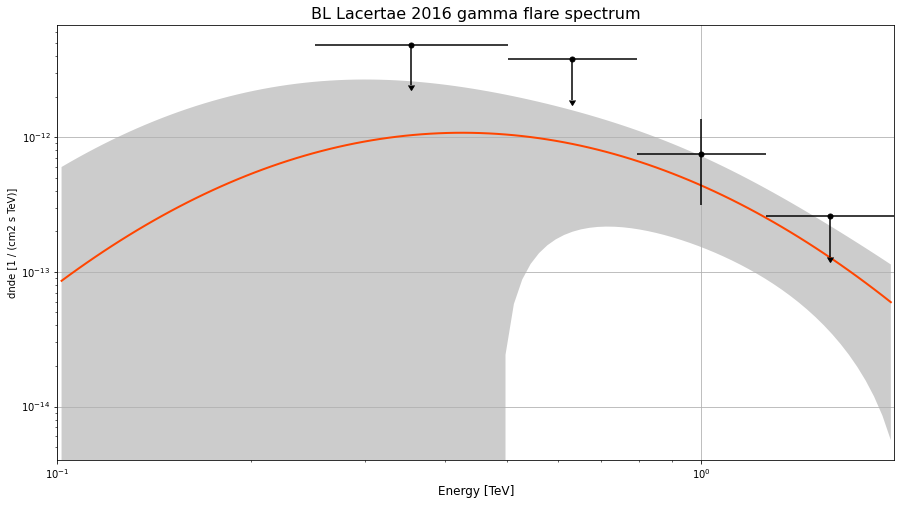

In [35]:
plt.figure(figsize=(15, 8))

energy_bounds = [e_min, e_max] * u.TeV

spectral_model.plot(energy_bounds, label='Log Parabola Fit', color='orangered', lw=2)
spectral_model.plot_error(energy_bounds, alpha=0.2, color='deepskyblue')
flux_points.plot(sed_type='dnde', color='k', markersize=5)

plt.xlabel('Energy [TeV]', fontsize=12)
plt.title('BL Lacertae 2016 gamma flare spectrum', fontsize=16)
plt.grid()

plt.show()

In [36]:
gammapy_flux = flux_points.to_table(sed_type='dnde')
gammapy_flux.show_in_notebook()

idx,e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred [5],npred_excess [5],stat,is_ul,counts [5],success,norm_scan [11],stat_scan [11]
,TeV,TeV,TeV,1 / (m2 s TeV),1 / (m2 s TeV),1 / (m2 s TeV),1 / (m2 s TeV),1 / (m2 s TeV),,,,,,,,,,
0,0.12589254117941673,0.10000000000000002,0.1584893192461114,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.0,False,0.0 .. 0.0,False,0.2 .. 4.999999999999999,nan .. nan
1,0.19952623149688806,0.1584893192461114,0.2511886431509581,-1.406052201595829e-07,2.9318214081484705e-08,7.044998413120692e-08,7.04499841312066e-08,nan,2.0432566196740787,-1.4294252760022395,0.0 .. 0.0,-0.50425565 .. 0.0,0.0015244585842921765,True,0.0 .. 0.0,True,0.2 .. 4.999999999999999,2.0606104644007566 .. 2.4405157318180386
2,0.3548133892335756,0.2511886431509581,0.5011872336272725,-1.168684711983328e-09,1.9153785025841617e-08,2.160482471898135e-08,nan,4.8487365524658147e-08,0.003677985874290357,-0.06064640034074864,1.3216672531492142 .. 1.005698886132684,-0.026158834 .. -0.024604144,17.867926293150433,True,0.0 .. 0.0,True,0.2 .. 4.999999999999999,17.895632458028025 .. 22.293192141366777
3,0.6309573444801935,0.5011872336272725,0.7943282347242819,8.91169612647615e-09,1.0819074079178656e-08,1.2616418878947092e-08,nan,3.8022171706738383e-08,0.9215682161489882,0.9599834457682008,0.7546153317808351 .. 0.7176501115547321,0.33681852 .. 0.3370165,6.104846110955175,True,1.0 .. 1.0,True,0.2 .. 4.999999999999999,6.6551722710026 .. 11.573696608730915
4,1.0000000000000004,0.7943282347242819,1.2589254117941677,7.484250093604087e-09,5.20036238705337e-09,6.102788300991111e-09,4.373016676407557e-09,2.1612305107116084e-08,4.29283566074508,2.071915939594336,0.8894497425422156 .. 0.7217405895391797,0.56608915 .. 0.5925865,6.251262156161147,False,1.0 .. 1.0,True,0.2 .. 4.999999999999999,9.213332699592726 .. 10.38707148591815
5,1.584893192461114,1.2589254117941677,1.9952623149688802,4.080966350195228e-15,2.065360927463635e-12,6.451902654657773e-10,nan,2.5807611183023012e-09,-6.325213768199056e-06,0.0,6.081013699934684e-07 .. 0.12121279046827942,6.0810135e-07 .. 6.692561e-07,0.936870489590166,True,0.0 .. 0.0,True,0.2 .. 4.999999999999999,1.333159168339585 .. 10.844239263456075


In [37]:
chi_sq, dof = reduced_chi_sq(gammapy_flux['dnde'], spectral_model(gammapy_flux['e_ref']), gammapy_flux['dnde_err'], 4)
print(chi_sq, dof)

nan 2


In [38]:
paper = Table.read('BL_Lacertae/bl_combine.fits', format='fits')
paper

E,dNdE,dNdE_errl,dNdE_erru,dNdE_ul,Hz,nuFnu,nuFnu_errl,nuFnu_erru,nuFnu_ul,Sigma
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),Hz,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.39810717055349704,2.594568396658546e-10,1.7531998788451783e-11,1.8328744267171375e-11,0.0,9.626188555952215e+25,6.588332629467718e-11,4.451863355250235e-12,4.654179248775704e-12,0.0,0.0
0.6309573444801928,6.225869491350621e-11,5.176365952855205e-12,5.47399791560092e-12,0.0,1.5256480711675739e+26,3.9710961850216795e-11,3.3016829402249626e-12,3.4915239180099986e-12,0.0,0.0
0.9999999999999992,1.2755113059947644e-11,1.6137508116126233e-12,1.7578911604462704e-12,0.0,2.417989242084916e+26,2.043594410867632e-11,2.5855138434642765e-12,2.8164521423821543e-12,0.0,0.0
1.584893192461112,1.7159468830440653e-12,4.112787859663585e-13,4.882137739821135e-13,0.0,3.83225468922459e+26,6.905803774837774e-12,1.655185612504906e-12,1.9648093752834976e-12,0.0,0.0
2.5118864315095766,0.0,0.0,0.0,5.61924080180172e-13,6.0737143687292305e+26,0.0,0.0,0.0,5.680519265456438e-12,0.0


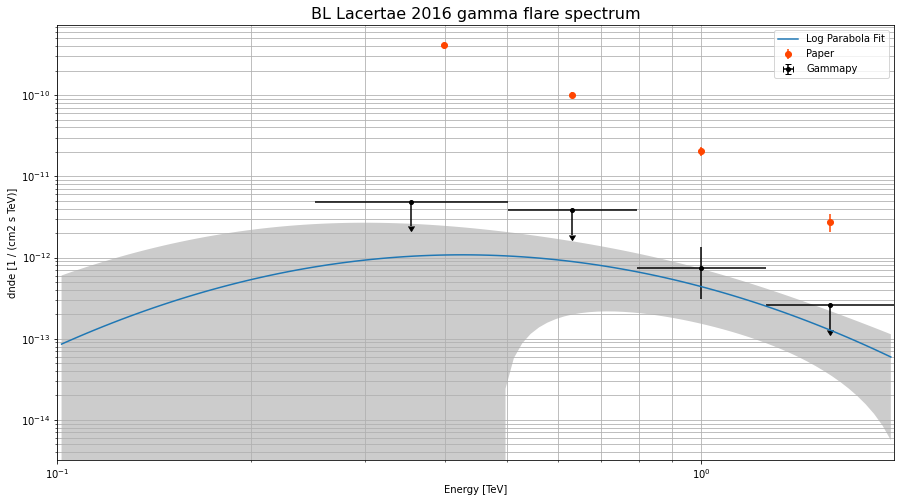

In [39]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.errorbar(paper['E'], paper['dNdE'] * 1.602, yerr=paper['dNdE_errl'] * 1.602, 
             color='orangered', ls='', marker='o', label='Paper')

flux_points.plot(ax=ax, sed_type="dnde", color="k", label='Gammapy')

spectral_model.plot(energy_bounds, sed_type='dnde', label='Log Parabola Fit')
spectral_model.plot_error(energy_bounds, sed_type='dnde', alpha=0.2)

ax.set_xscale('log')
ax.grid(which='minor')
ax.grid(which='major')
ax.legend()

plt.title('BL Lacertae 2016 gamma flare spectrum', fontsize=16)

plt.show()

In [50]:
start_mjd = Time(57666.165, format='mjd')
print(start_mjd.iso)

2016-10-05 03:57:36.000


In [54]:
t0 = Time('2016-10-05T03:57:36.000')

duration = 200 * u.min
n_time_bins = 6
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])]

In [55]:
short_observations = observations.select_time(time_intervals)

print(f"Number of observations after time filtering: {len(short_observations)}\n")
print(short_observations[1].gti)

Number of observations after time filtering: 5

GTI info:
- Number of GTIs: 1
- Duration: 1801.0 s
- Start: 368425591.8900612 s MET
- Start: 2016-10-05T04:26:27.890 (time standard: UTC)
- Stop: 368427392.8900612 s MET
- Stop: 2016-10-05T04:56:28.890 (time standard: UTC)



In [59]:
#redo?

dataset_maker = SpectrumDatasetMaker(containment_correction=False, selection=["counts", "exposure", "edisp"])
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

datasets = Datasets()

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

for obs in short_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)
    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

In [60]:
spectral_model.parameters.frozen = False
sky_model = SkyModel(spatial_model=None, spectral_model=spectral_model, name="BL Lacertae")

In [61]:
datasets.models = sky_model

In [62]:
lc_maker_1d = LightCurveEstimator(energy_edges=[0.2, 5] * u.TeV, source=0, 
                                  time_intervals=time_intervals, selection_optional=None)

In [63]:
lc_1d = lc_maker_1d.run(datasets)

In [64]:
header="""# %ECSV 1.0
# ---
# datatype:
# - {name: time_min, datatype: float64}
# - {name: time_max, datatype: float64}
# - {name: e_ref, unit: TeV, datatype: string, subtype: 'float64[1]'}
# - {name: e_min, unit: TeV, datatype: string, subtype: 'float64[1]'}
# - {name: e_max, unit: TeV, datatype: string, subtype: 'float64[1]'}
# - {name: flux, unit: 1 / (m2 s), datatype: string, subtype: 'float64[1]'}
# - {name: flux_err, unit: 1 / (m2 s), datatype: string, subtype: 'float64[1]'}
# - {name: ts, unit: '', datatype: string, subtype: 'float64[1]'}
# - {name: sqrt_ts, unit: '', datatype: string, subtype: 'float64[1]'}
# - {name: npred, unit: '', datatype: string, subtype: 'float64[1,44]'}
# - {name: npred_excess, unit: '', datatype: string, subtype: 'float64[1,44]'}
# - {name: stat, unit: '', datatype: string, subtype: 'float64[1]'}
# - {name: is_ul, datatype: string, subtype: 'bool[1]'}
# - {name: counts, unit: '', datatype: string, subtype: 'float64[1,44]'}
# - {name: success, unit: '', datatype: string, subtype: 'bool[1]'}
# schema: astropy-2.0
time_min time_max e_ref e_min e_max flux flux_err ts sqrt_ts npred npred_excess stat is_ul counts success"""

In [65]:
with open("temptest.ecsv", "w") as myfile:
    myfile.write(header)

filename = 'BL_Lacertae/bl_combine.fits'

imp_tab = Table.read(filename)

imp_tab["e_max"] = imp_tab["e_cut"]
imp_tab["e_ref"] = np.exp(np.log(imp_tab["e_min"]) + np.log(imp_tab["e_max"]) / 2)

imp_tab["time_min"] = imp_tab["e_cut"]
imp_tab["time_max"] = imp_tab["time"] + (imp_tab["time_bin"] / 2.01)
imp_tab["time_min"] = imp_tab["time"] - (imp_tab["time_bin"] / 2.01)

extend = '[[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,' \
+ 'NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] ' \
+ '[[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,' \
+ 'NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] [0.0] [false] ' \
+ '[[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,' \
+ 'NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] [true]'

for i in range(len(imp_tab)):

    with open("temptest.ecsv", "a") as myfile:
        myfile.write(f'\n{imp_tab[i]["time_min"]} {imp_tab[i]["time_max"]} [{imp_tab[i]["e_ref"]}] ' \
                     + f'[{imp_tab[i]["e_min"]}] [{imp_tab[i]["e_max"]}] [{imp_tab[i]["flux"]}] ' \
                     + f'[{imp_tab[i]["flux_err"]}] [0] [0] {extend}')

lc_test=FluxPoints.read('temptest.ecsv', reference_model=spectral_model, sed_type='flux', format='lightcurve')

KeyError: 'e_cut'

In [ ]:
plt.figure(figsize=(15, 8))
lc_test.plot(sed_type='dnde', marker="o")
plt.show()

NameError: name 'lc_test' is not defined

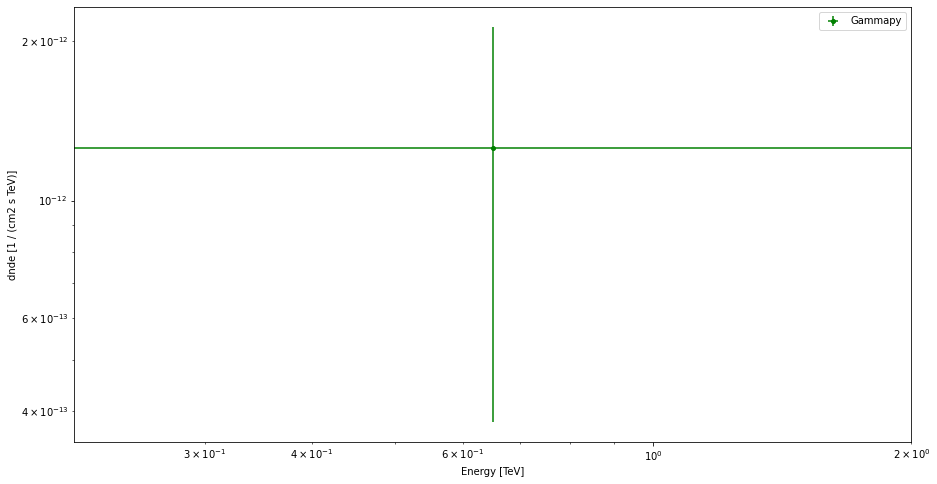

In [67]:
plt.figure(figsize=(15, 8))
lc_1d.plot(marker="o", color='g',label='Gammapy')
lc_test.plot(sed_type='dnde', marker="o", color='darkgoldenrod')

#lc_test2.plot(sed_type='dnde',marker="o",label='Eventdisplay')
plt.ylabel(r'$dN/dE$ [cm$^{-2}$ s$^{-1}$ TeV$^{-1}$]  for $E$ > 200 GeV')
plt.title('BL Lacertae 2016 gamma flare lightcurve')
plt.grid()

plt.show()